In [16]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
import seaborn as sns
import matplotlib.pyplot as plt
import re
from nltk import WordNetLemmatizer
import string
#display full dataframe information
pd.set_option('display.max_colwidth', 50)

In [17]:
df = pd.read_csv(r'C:\Users\efere\Downloads\Dataset\news.csv')
df.head()

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6335 entries, 0 to 6334
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  6335 non-null   int64 
 1   title       6335 non-null   object
 2   text        6335 non-null   object
 3   label       6335 non-null   object
dtypes: int64(1), object(3)
memory usage: 198.1+ KB


In [19]:
df.rename(columns={'Unnamed: 0':'ID'}, inplace=True)

In [20]:
df.head()

,ID,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [21]:
df['label'].value_counts().to_frame()

,label
REAL,3171
FAKE,3164


In [22]:
def remove_punct(text):
    return ("".join([ch for ch in text if ch not in string.punctuation]))
def tokenize(text):
    text = re.split('\s+', text)
    return [x.lower() for x in text]
def lemmatize(text):
    word_net = WordNetLemmatizer()
    return [word_net.lemmatize(word) for word in text]
def return_sentence(tokens):
    return (" ".join([str(word) for word in tokens]))

In [23]:
removed_punc = df['text'].apply(lambda x: remove_punct(x))
tokens = removed_punc.apply(lambda x: tokenize(x))
lemmatized_words = tokens.apply(lambda x: lemmatize(x))
final_text = lemmatized_words.apply(lambda x: return_sentence(x))

In [24]:
X = final_text
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [25]:
#stop words refer to common words often used in english like 'a','an','or','but' etc
#max_df means ignoring words that appear in more than 70% of the documents 
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df = 0.7)
tfidf_train = tfidf_vectorizer.fit_transform(X_train)
tfidf_test = tfidf_vectorizer.transform(X_test)

In [26]:
state = 42
regularization_parameter = 1
classifiers = {
    'Passive Aggressive Classifier' : PassiveAggressiveClassifier(
        C = regularization_parameter,
        max_iter=50,
        random_state=state
    ),
    'Logistic Regression' : LogisticRegression(
        C = regularization_parameter,
        random_state=state
    ),
    'Multi-Nominal Naive Bayes' : MultinomialNB()
}

Passive Aggressive Classifier: 80
Accuracy of 93.69% was obtained using Passive Aggressive Classifier
Accuracy of 93.67%, with a percent standard deviation of 0.71% using cross-validation
              precision    recall  f1-score   support

        FAKE       0.94      0.93      0.93       615
        REAL       0.93      0.94      0.94       652

    accuracy                           0.94      1267
   macro avg       0.94      0.94      0.94      1267
weighted avg       0.94      0.94      0.94      1267

Logistic Regression: 109
Accuracy of 91.4% was obtained using Logistic Regression
Accuracy of 91.62%, with a percent standard deviation of 0.31% using cross-validation
              precision    recall  f1-score   support

        FAKE       0.90      0.92      0.91       615
        REAL       0.92      0.91      0.92       652

    accuracy                           0.91      1267
   macro avg       0.91      0.91      0.91      1267
weighted avg       0.91      0.91      0.91  

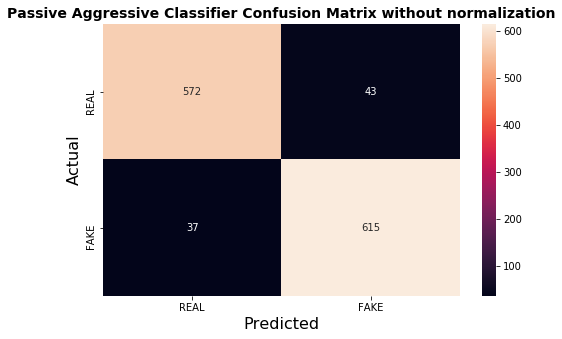

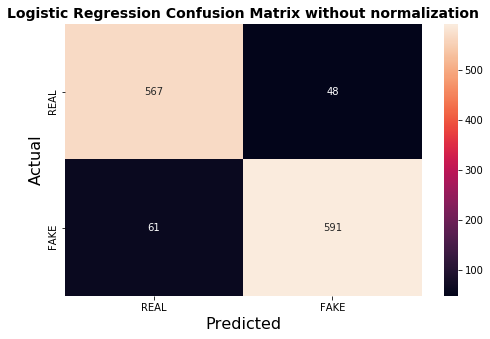

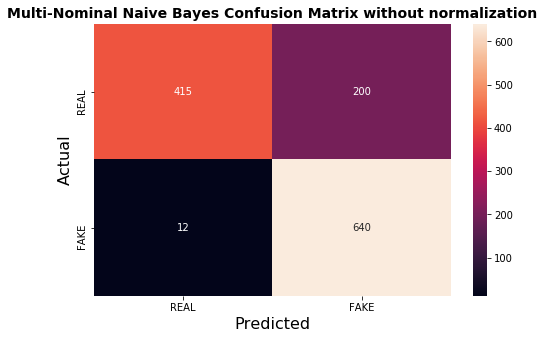

In [27]:
for i, (clf_name, clf) in enumerate(classifiers.items()):
    clf.fit(tfidf_train, y_train)
    y_hat = clf.predict(tfidf_test)
    score = accuracy_score(y_test, y_hat)
    n_errors = (y_test!=y_hat).sum()
    cvs_score = cross_val_score(clf, tfidf_vectorizer.transform(X), y, cv=5)
    print(f"{clf_name}: {n_errors}")
    print(f'Accuracy of {round(score*100, 2)}% was obtained using {clf_name}')
    print(f'Accuracy of {round(cvs_score.mean()*100, 2)}%, '
          f'with a percent standard deviation of {round(cvs_score.std()*100,2)}% using cross-validation')
    print(classification_report(y_test, y_hat))
    plt.figure(figsize=(8,5))
    cm = confusion_matrix(y_test, y_hat)
    #fmt helps to change the display of the integer to the desired format
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=['REAL', 'FAKE'], yticklabels=['REAL','FAKE'])
    plt.xlabel('Predicted', fontsize=16)
    plt.ylabel('Actual', fontsize=16)
    plt.title(f'{clf_name} Confusion Matrix without normalization', fontsize=14, fontweight='bold')

## CONCLUSION
The aim of the project was to build Machine Learning models to predict fake news accurately. After cleaning, transforming and evaluating different classification models, the Passive Aggressive Classifier was found to be the most accurate model for prediction. 